In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import joblib
import tabulate as tb
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras import Sequential, layers, optimizers, losses

In [ ]:
CSV_PATH = './../data/GOOGL.csv'
DATE_COL = 'Date'

SEQ_LENGTH = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 30


FEATURES = [
    'rsi', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9',
    'BBL_20_2.0_2.0','BBM_20_2.0_2.0','BBU_20_2.0_2.0','BBB_20_2.0_2.0','BBP_20_2.0_2.0',
    'ema_10','ema_20','ema_50','atr','stoch_k','stoch_d'
]

TARGET = 'Open'

TRAINING_RANGE = ('2004-08-19', '2017-01-01')
TESTING_RANGE = ('2017-01-01', '2019-12-19')

In [33]:
df = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL])
df = df.sort_values(DATE_COL).reset_index(drop=True)
df = df[[DATE_COL] + FEATURES + [TARGET]]
df.dropna(inplace=True)
    
feature_scaler = StandardScaler()
target_scaler = MinMaxScaler()

feature_data = feature_scaler.fit_transform(df[FEATURES])
target_data = target_scaler.fit_transform(df[[TARGET]].values.reshape(-1, 1))

print(tb.tabulate(feature_data[:5], headers=FEATURES, tablefmt='psql'))
print(tb.tabulate(target_data[:5], headers=[TARGET], tablefmt='psql'))

+---------+----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------+-----------+-----------+-----------+-----------+-----------+
|     rsi |   MACD_12_26_9 |   MACDh_12_26_9 |   MACDs_12_26_9 |   BBL_20_2.0_2.0 |   BBM_20_2.0_2.0 |   BBU_20_2.0_2.0 |   BBB_20_2.0_2.0 |   BBP_20_2.0_2.0 |    ema_10 |    ema_20 |    ema_50 |       atr |   stoch_k |   stoch_d |
|---------+----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------+-----------+-----------+-----------+-----------+-----------|
| 2.26036 |      0.069751  |        0.240104 |      0.00367968 |        -0.96256  |        -0.943708 |        -0.925648 |          6.036   |         1.38459  | -0.933339 | -0.942117 | -0.960079 | -0.758485 |   1.08159 |   1.02797 |
| 2.02674 |      0.0807454 |        0.222327 |      0.0204574  |        

In [34]:
X, y = [], []
dates = []
for i in range(SEQ_LENGTH, len(feature_data)):
    tmp = feature_data[i - SEQ_LENGTH:i]
    X.append(tmp)
    dates.append(df[DATE_COL].values[i])
    y.append(target_data[i])

X, y = np.array(X), np.array(y)

print(f"Feature data shape: {X.shape}")
print(f"Target data shape: {y.shape}")

Feature data shape: (5229, 50, 15)
Target data shape: (5229, 1)


In [35]:
def find_closest_date_index(dates_array, target_date):
    target_date = np.datetime64(target_date)
    index = np.argmin(np.abs(dates_array - target_date))
    return index

train_beg, train_end = find_closest_date_index(dates, TRAINING_RANGE[0]), find_closest_date_index(dates, TRAINING_RANGE[1])
test_beg, test_end = find_closest_date_index(dates, TESTING_RANGE[0]), find_closest_date_index(dates, TESTING_RANGE[1])

print(f"Training: beg_idx={train_beg} -> beg={dates[train_beg]} || end_idx={train_end} -> end={dates[train_end]}")
print(f"Testing:  beg_idx={test_beg} -> beg={dates[test_beg]} || end_idx={test_end} -> end={dates[test_end]}")

X_train, y_train = X[train_beg:train_end+1], y[train_beg:train_end+1]
X_test, y_test = X[test_beg:test_end+1], y[test_beg:test_end+1]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Training: beg_idx=0 -> beg=2005-01-10T00:00:00.000000000 || end_idx=3015 -> end=2016-12-30T00:00:00.000000000
Testing:  beg_idx=3015 -> beg=2016-12-30T00:00:00.000000000 || end_idx=3762 -> end=2019-12-19T00:00:00.000000000
X_train shape: (3016, 50, 15), y_train shape: (3016, 1)
X_test shape: (748, 50, 15), y_test shape: (748, 1)


In [36]:
def create_financial_model(seq_length, feature_count, learning_rate):
    model = Sequential([
        layers.Input(shape=(seq_length, feature_count)),
        layers.LSTM(96, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(96, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(96, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(96),
        layers.Dropout(0.2),
        layers.Dense(1),
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=["mse"]
    )
    
    model.summary()
    return model
model = create_financial_model(SEQ_LENGTH, len(FEATURES), LEARNING_RATE)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 50, 96)         │        43,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 50, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 50, 96)         │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 50, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 50, 96)         │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 50, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 96)             │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,441 (1.01 MB)

 Trainable params: 265,441 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
]

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - loss: 0.0019 - mse: 0.0019 - learning_rate: 0.0010
Epoch 2/30
 1/95 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - loss: 3.3826e-04 - mse: 3.3826e-04

d:\PrivateProjects\WhiteRock\.venv\Lib\site-packages\keras\src\callbacks\callback_list.py:171: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mse,learning_rate.
  callback.on_epoch_end(epoch, logs)


95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 1.6449e-04 - mse: 1.6449e-04 - learning_rate: 0.0010
Epoch 3/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 1.1596e-04 - mse: 1.1596e-04 - learning_rate: 0.0010
Epoch 4/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 8.8871e-05 - mse: 8.8871e-05 - learning_rate: 0.0010
Epoch 5/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 7.7896e-05 - mse: 7.7896e-05 - learning_rate: 0.0010
Epoch 6/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 6.5783e-05 - mse: 6.5783e-05 - learning_rate: 0.0010
Epoch 7/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 5.6612e-05 - mse: 5.6612e-05 - learning_rate: 0.0010
Epoch 8/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 5.6124e-05 - mse: 5.6124e-05 - learning_rate: 0.0010
Epoch 9/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 5.2359e-05 - mse: 5.2359e-05 - learning_rate: 0.0010
Epoch 10/30
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - loss: 4.8377e-05 - mse: 4.8377e-05 - learni

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step
+-----+---------------------+----------+-------------+
|     | Date                |   Actual |   Predicted |
|-----+---------------------+----------+-------------|
|   0 | 2016-12-30 00:00:00 |  39.8854 |     38.6682 |
|   1 | 2017-01-03 00:00:00 |  39.7568 |     38.5108 |
|   2 | 2017-01-04 00:00:00 |  40.2171 |     38.3751 |
|   3 | 2017-01-05 00:00:00 |  40.0984 |     38.3162 |
|   4 | 2017-01-06 00:00:00 |  40.4704 |     38.3672 |
|   5 | 2017-01-09 00:00:00 |  41.0355 |     38.5638 |
|   6 | 2017-01-10 00:00:00 |  41.0702 |     38.8666 |
|   7 | 2017-01-11 00:00:00 |  41.0479 |     39.1815 |
|   8 | 2017-01-12 00:00:00 |  41.1353 |     39.4377 |
|   9 | 2017-01-13 00:00:00 |  41.2654 |     39.5949 |
|  10 | 2017-01-17 00:00:00 |  41.2157 |     39.6496 |
|  11 | 2017-01-18 00:00:00 |  41.2058 |     39.604  |
|  12 | 2017-01-19 00:00:00 |  41.1661 |     39.4859 |
|  13 | 2017-01-20 00:00:00 |  41.1705 |     39.3146 |
|  14 | 2017-01-23 00:00:

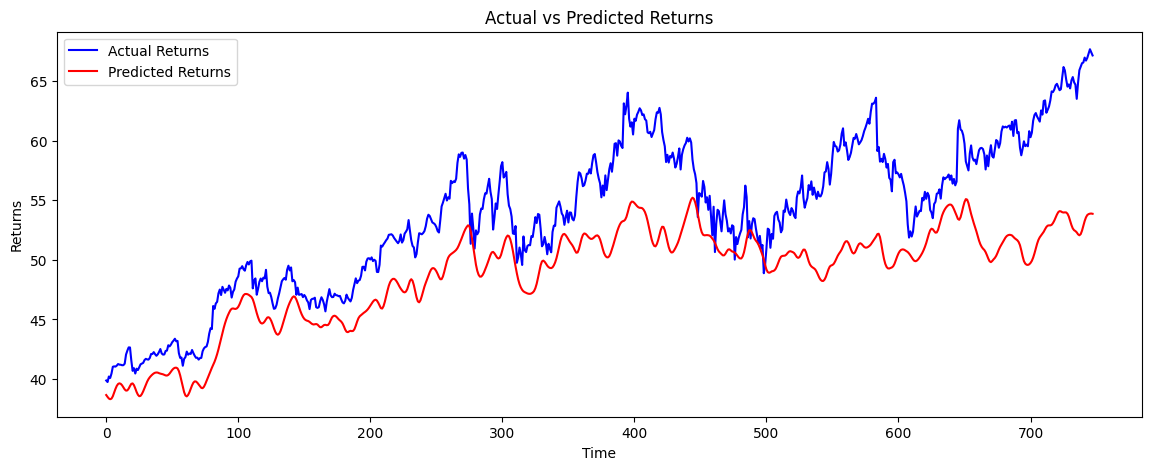

In [ ]:
predictions_scaled = model.predict(X_test)
predictions = target_scaler.inverse_transform(predictions_scaled).flatten()
y_test_unscaled = target_scaler.inverse_transform(y_test).flatten()

comp_df = pd.DataFrame({
    'Date': df[DATE_COL].values[test_beg + SEQ_LENGTH:test_end + SEQ_LENGTH + 1],
    'Actual': y_test_unscaled,
    'Predicted': predictions
})
print(tb.tabulate(comp_df, headers='keys', tablefmt='psql'))

mse = mean_squared_error(y_test_unscaled, predictions)
mae = mean_absolute_error(y_test_unscaled, predictions)
r2 = r2_score(y_test_unscaled, predictions)
print(f"Test MSE: {mse:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test R2: {r2:.3f}")


plt.figure(figsize=(14, 5))
plt.plot(y_test_unscaled, color='blue', label='Actual Returns')
plt.plot(predictions, color='red', label='Predicted Returns')
plt.title('Actual vs Predicted Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()